# Módulo 6 - Aprendizado profundo

Neste notebook, utilizaremos a biblioteca [Keras](https://www.keras.io) para construir uma rede neural do tipo Convolutional Neural Networks (CNN). Neste exemplo, iremos criar uma CNN para classificar imagens do dataset CIFAR-10. As imagens deste dataset são classificadas em 10 categorias. O objetivo é entender como este tipo de rede funciona. Ao final, você deverá realizar os exercícios propostos.

Para começar, precisamos importar algumas bibliotecas.

In [ ]:
import keras
from keras.datasets import cifar10
#from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Para utilizar o dataset CIFAR-10, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída).

In [ ]:
# carrega os conjuntos de treino e teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Podemos visualizar alguns exemplos (de entrada e saída) do dataset utilizando o código abaixo.

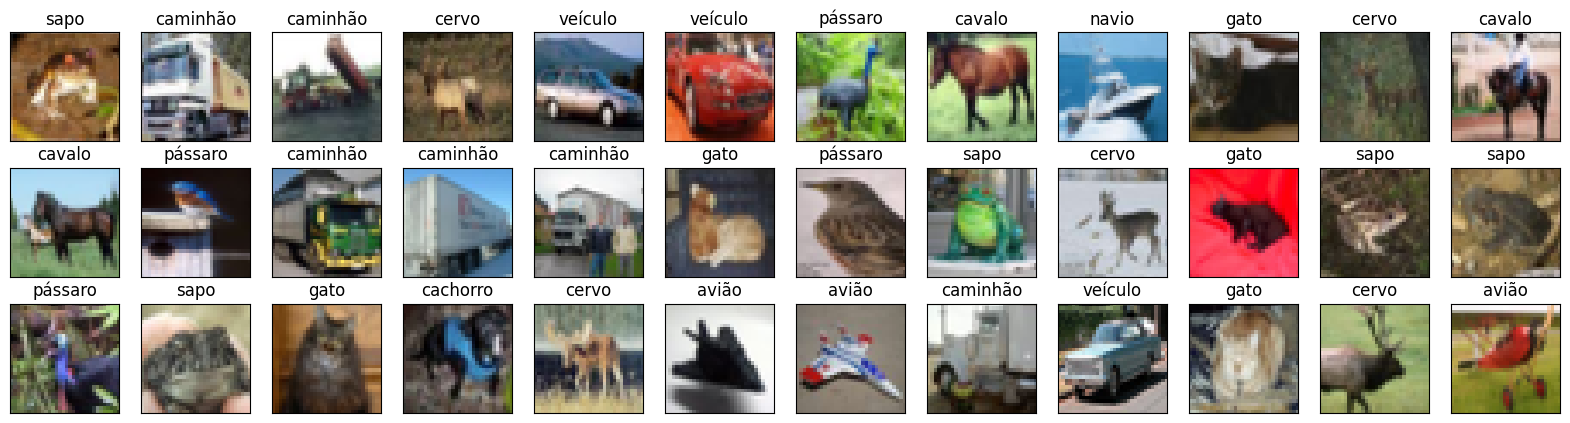

In [ ]:
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar10_labels[y_train[i][0]]))

Após carregar os dados, devemos tratá-los para melhorar o treinamento. No nosso caso, vamos apenas normalizar as cores (atualmente no intervalo [0,255]) para o intervalo [0,1].

In [ ]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Em seguida, podemos codificar as classes utilizando o one-hot encoding. Isto vai facilitar o aprendizado.

In [ ]:
# codificação one-hot das categorias
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Outro passo importante é separar uma parte do conjunto de treino para validação. O objetivo é reduzir o bias do conjunto de teste.

In [ ]:
# divide os dados em treino, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [ ]:
# imprime o formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# imprime o tamanho dos conjuntos
print(x_train.shape[0], 'amostras de treino')
print(x_valid.shape[0], 'amostras de validação')
print(x_test.shape[0], 'amostras de teste')

Formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
5000 amostras de validação
10000 amostras de teste


Processados os dados, agora devemos criar a CNN. Como de costume, trabalharemos com um modelo sequencial.

In [ ]:
model = Sequential()

Em seguida, podemos empilhar as camadas de convolução e agrupamento desejadas. Neste nosso caso, estamos trabalhando com 3 camadas convolucionais, cada qual com kernel de tamanho 2x2 e função de ativação ReLU. Após cada camada convolucional empilhamos uma camada de max pooling com kernel de tamanho 2x2.

In [ ]:
# Primeira camada convolucional
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Segunda camada convolucional
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Terceira camada convolucional
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# Camada Flatten e Densa
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Lembre-se que as camadas convolucionais servem como um extrator de features, as quais serão utilizadas por um classificador MLP. Desta forma, agora precisamos converter a saída da parte convolucional para um vetor, que é o formato aceito por uma MLP. Isto pode ser feito com uma camada `Flatten`, como abaixo.

In [ ]:
model.add(Flatten())

Finalmente, agora podemos adicionar as camadas densas de uma MLP para realizar a classificação. Note também que estamos utilizando Dropout para reduzir o overfitting.

In [ ]:
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

Nossa rede resultante é resumida abaixo.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │             550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,342,286 (5.12 MB)

 Trainable params: 1,342,286 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

O próximo passo é compilar nosso modelo. Os parâmetros abaixo foram escolhidos por serem próprios para classificação.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Agora podemos finalmente treinar nosso modelo. **Cuidado, este processo pode demorar bastante!**  Para facilitar o estudo, reduzimos para apenas 10 épocas. Tente aumentar o número de épocas para ver entender melhor o efeito deste parâmetro nos resultados.

Note que antes do treino, criamos um checkpoint. Um checkpoint permite que o modelo seja salvo em um arquivo. No nosso caso, apenas o melhor modelo será salvo. Desta forma, poderemos carregar nosso modelo posteriormente sem precisar treinar novamente a rede.

In [ ]:
# cria um checkpoint para salvar os pesos do melhor modelo encontrado no trainamento
checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)

# treina o modelo
hist = model.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer],
          verbose=1, shuffle=True)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1476 - loss: 2.2165
Epoch 1: val_loss improved from inf to 1.85171, saving model to model.weights.best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.1476 - loss: 2.2164 - val_accuracy: 0.2722 - val_loss: 1.8517
Epoch 2/10
1397/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2603 - loss: 1.8646
Epoch 2: val_loss improved from 1.85171 to 1.62705, saving model to model.weights.best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.2605 - loss: 1.8643 - val_accuracy: 0.3902 - val_loss: 1.6270
Epoch 3/10
1396/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3825 - loss: 1.6282
Epoch 3: val_loss improved from 1.62705 to 1.54780, saving model to model.weights.best.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3828 - loss: 1.6279 - val_accuracy: 0.4262 - val_loss: 1.5478
Epoch 4/10
1399/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4831 - loss: 1.4498
Epoch 4: val

Treinado o modelo, podemos analisar seu desempenho através dos gráficos abaixo.

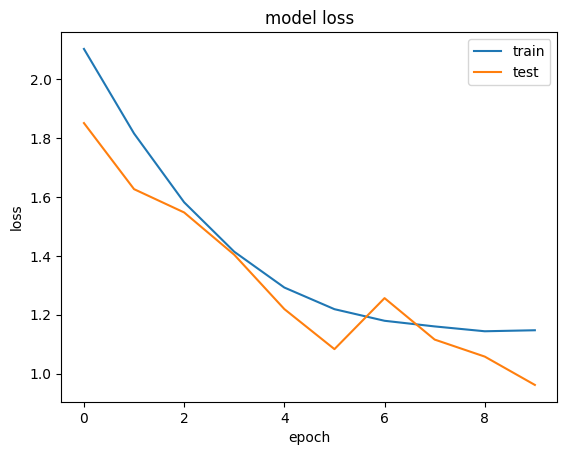

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

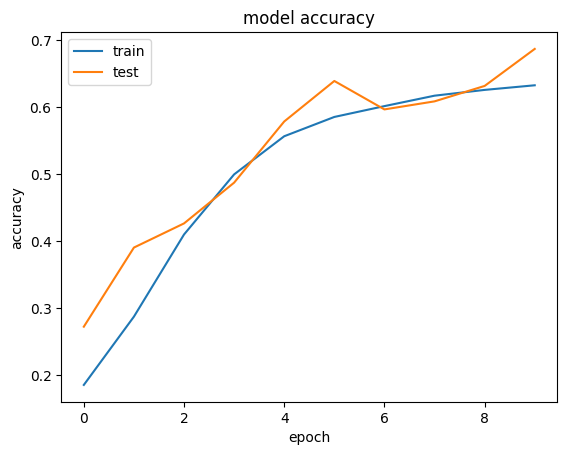

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como pode ser observado, nossa rede CNN conseguiu obter resultados bem interessantes mesmo sem uma otimização dos hiper-parâmetros.

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [ ]:
# carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model.weights.best.keras')

A acurácia pode ser medida como segue.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.6769999861717224


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


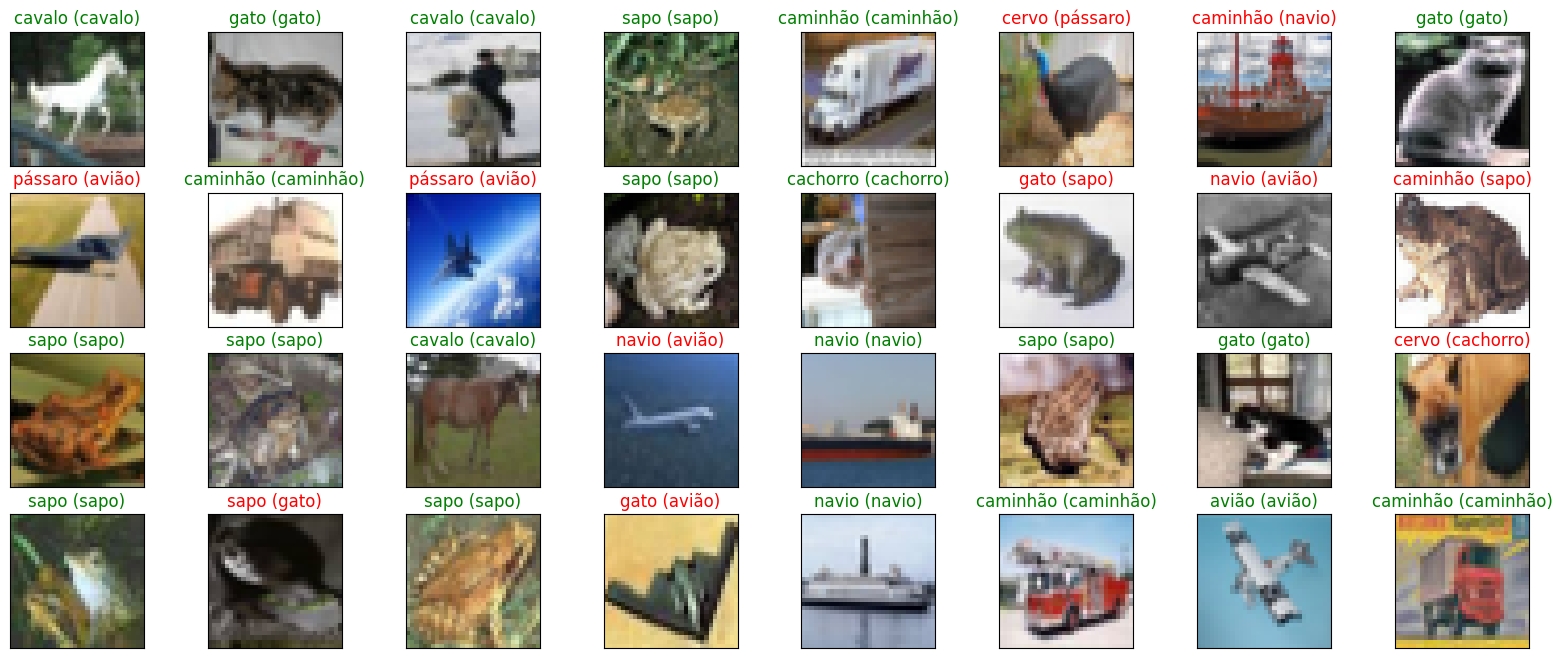

In [ ]:
# obtém as predições
y_hat = model.predict(x_test)

# define os labels (fonte: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

## Exercícios

### Exercício 1

Ajuste a rede CNN vista acima para obter uma acurácia melhor no dataset CIFAR-10. Sua tarefa consiste em modificar a arquitetura da rede (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.).

In [ ]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                          BatchNormalization, Activation)
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('Formato dos dados de entrada:', x_train.shape)
print(x_train.shape[0], 'amostras de treino')
print(x_valid.shape[0], 'amostras de validação')
print(x_test.shape[0], 'amostras de teste')

Formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
5000 amostras de validação
10000 amostras de teste


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 8, 8, 128)           │              

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
optimizer = Adam(learning_rate=0.0001)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='best_model.keras', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)

In [ ]:
epochs = 20
batch_size = 64

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2058 - loss: 2.4990
Epoch 1: val_loss improved from inf to 1.95870, saving model to best_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.2059 - loss: 2.4987 - val_accuracy: 0.3296 - val_loss: 1.9587 - learning_rate: 1.0000e-04
Epoch 2/20
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3633 - loss: 1.9255
Epoch 2: val_loss improved from 1.95870 to 1.71245, saving model to best_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3633 - loss: 1.9252 - val_accuracy: 0.4430 - val_loss: 1.7125 - learning_rate: 1.0000e-04
Epoch 3/20
699/704 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4265 - loss: 1.7715
Epoch 3: val_loss improved from 1.71245 to 1.62782, saving model to best_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4266 - loss: 1.7713 - val_accuracy: 0.4768 - val_loss: 1.6278 - learning_rate: 1.0000e-04
Epoch 4/20
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

In [ ]:
model.load_weights('best_model.keras')

score = model.evaluate(x_test, y_test, verbose=0)
print('Acurácia no conjunto de teste:', score[1])

Acurácia no conjunto de teste: 0.7638999819755554


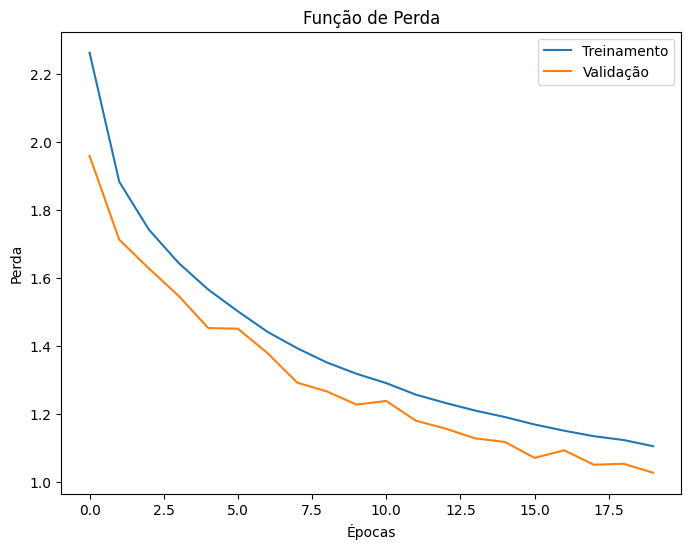

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Função de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

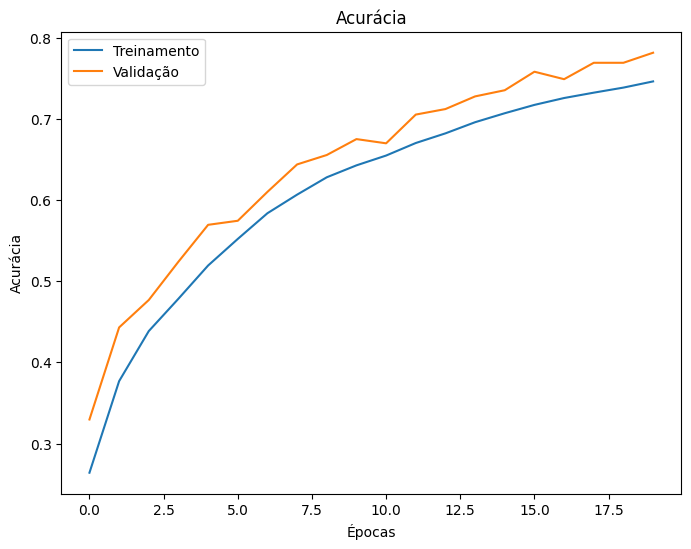

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


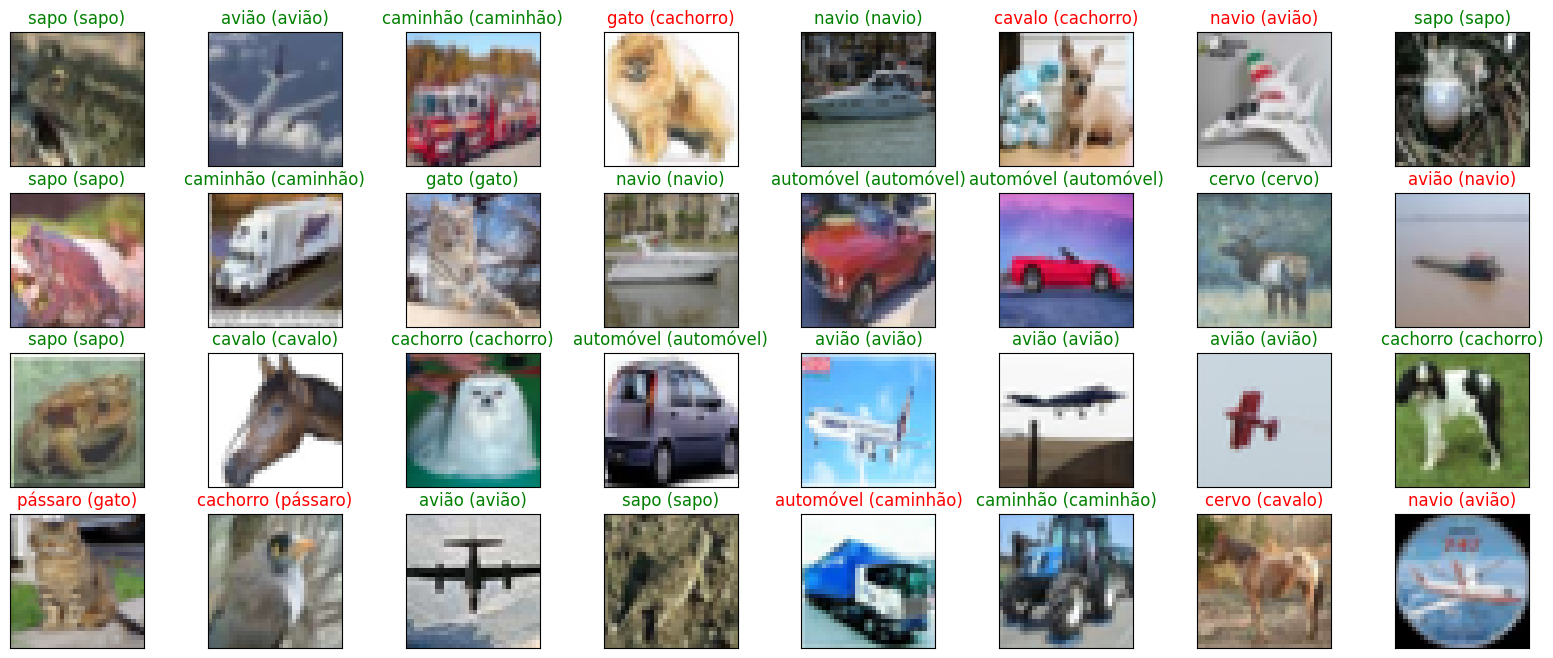

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cifar10_labels = ['avião', 'automóvel', 'pássaro', 'gato', 'cervo',
                  'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_pred_classes[idx]
    true_idx = y_true[idx]
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
plt.show()